In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import random
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [2]:
def set_random_seed(SEED=1234):
   random.seed(SEED)
   np.random.seed(SEED)
   torch.manual_seed(SEED)
   torch.cuda.manual_seed(SEED)
   torch.cuda.manual_seed_all(SEED)
   torch.backends.cudnn.enabled = True
   torch.backends.cudnn.benchmark = False
   torch.backends.cudnn.deterministic = True

set_random_seed()

In [3]:
def load_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    #dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    return dataset

In [4]:
def score_estimate(x, y_samples, t, beta):

    device = x.device
    y_samples = y_samples.to(device)
    
    x_flat = x.view(x.shape[0], -1)
    y_flat = y_samples.view(y_samples.shape[0], -1)
    
    sqrt_beta = torch.sqrt(torch.tensor(beta, device=device))
    coth_term = torch.cosh(sqrt_beta * (1 - t)) / torch.sinh(sqrt_beta * (1 - t))
    
    x_squared = (x_flat ** 2).sum(dim=1, keepdim=True)
    y_squared = (y_flat ** 2).sum(dim=1, keepdim=True)
    xy_term = torch.matmul(x_flat, y_flat.t())
    
    log_exponent = -sqrt_beta * ((x_squared + y_squared.t()) * coth_term * 0.5 - xy_term / torch.sinh(sqrt_beta * (1 - t)))
    log_exponent += y_squared.t() * sqrt_beta * torch.cosh(sqrt_beta) / (2 * torch.sinh(sqrt_beta))
    log_exponent_max = torch.max(log_exponent, dim=1, keepdim=True)[0]
    weights = torch.exp(log_exponent - log_exponent_max)
    #print(weights.shape)
    
    # Reshape x_term and y_term
    x_term = sqrt_beta * (coth_term - 1) * x_flat  # Shape: [4, 784]
    y_term = sqrt_beta * y_flat / torch.sinh(sqrt_beta * (1 - t))  # Shape: [60000, 784]
    
    # Calculate diff
    diff = y_term.unsqueeze(1) - x_term.unsqueeze(0)  # Shape: [60000, 4, 784]
    
    # Adjust weights shape for broadcasting
    weights = weights.transpose(0, 1).unsqueeze(-1)  # Shape: [60000, 4, 1]
    
    # Calculate numerator and denominator
    numerator = (diff * weights).sum(dim=0)  # Shape: [4, 784]
    denominator = weights.sum(dim=0)  # Shape: [4, 1]

    #x_hat = (y_flat.unsqueeze(0) * weights).sum(dim=0) / denominator
    x_hat = (y_flat.unsqueeze(1) * weights).sum(dim=0) / denominator
    
    score = numerator /denominator
    batch_size, channels, height, width = x.shape
    return score.view(batch_size, channels, height, width), x_hat.view(batch_size, channels, height, width)


In [5]:
 #Main execution
mnist_dataset = load_dataset()
y_samples = torch.stack([img for img, _ in mnist_dataset]).to(device)


Files already downloaded and verified


In [6]:
beta = 100
eps = 1e-3
num_steps = 512
_, chan, w, h = y_samples.shape
batch_size = 2
t = torch.linspace(0, 1-eps, num_steps, device=device)
delta_t = t[1] - t[0]
x = torch.zeros(batch_size, chan, w, h, device= device)
s = torch.zeros(num_steps, batch_size, chan, w, h, device= device)
ss = torch.zeros(num_steps, batch_size, chan, w, h, device= device)

for  i, tt in enumerate(t):
    u, cvx_comb = score_estimate(x, y_samples, tt, beta)
    x  = x + u * delta_t + torch.randn_like(x, device=device) * torch.sqrt(delta_t)
    s[i, :, :, :, :] = cvx_comb
    ss[i, :, :, :, :] = x

torch.save(s, 'cvx_comb_beta100.pt')
torch.save(ss, 'x_beta100.pt')


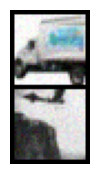

In [7]:
def plot_images(images):
    images =  (images * 127.5 + 128).clip(0, 255).to(torch.uint8)
    sample_grid = make_grid(images, nrow=int(np.sqrt(images.shape[0])))
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(sample_grid.cpu().permute(1, 2, 0).squeeze())
    plt.show()

plot_images(x)

In [8]:
import os
def plot_images(images, padding=1):
    """
    Plot images on a grid with small white gaps between them.
    
    Args:
    images (torch.Tensor): 4D tensor of shape (batch_size, channels, height, width)
    padding (int): Number of pixels for padding between images
    """
    # Normalize and convert to uint8
    images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8)
    
    # Create grid with small padding and no normalization
    sample_grid = make_grid(images, nrow=int(np.sqrt(images.shape[0])), 
                            padding=padding, normalize=False, 
                            pad_value=255)  # White padding
    
    # Create figure
    plt.figure(figsize=(10, 10))
    
    # Display image
    plt.imshow(sample_grid.cpu().permute(1, 2, 0).squeeze())
    plt.axis('off')
    
    # Remove any potential remaining space around the image
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    save_path = os.getcwd()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    
    plt.show()

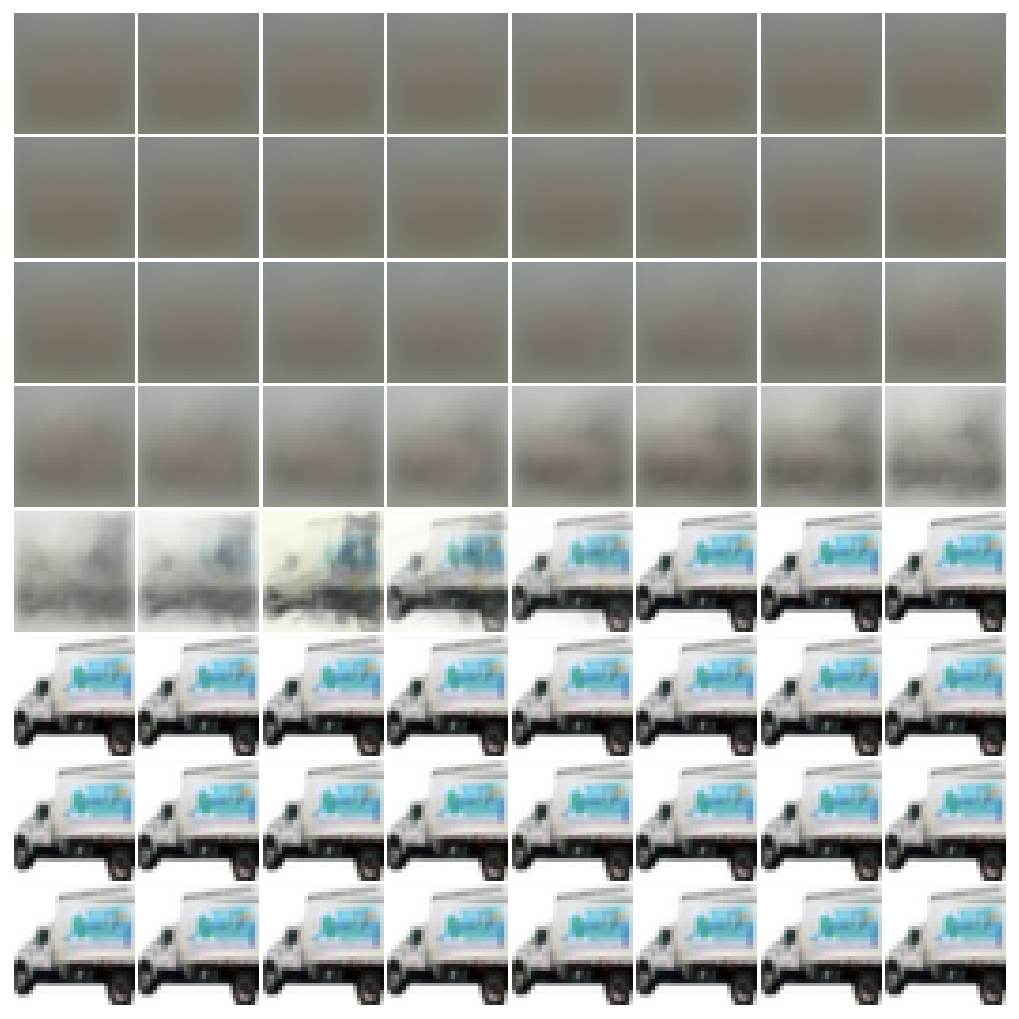

In [9]:
k = 0
plot_images(s[0:-1:8,k,:,:,:])
#plot_images(ss[0:-1:2,k,:,:,:])

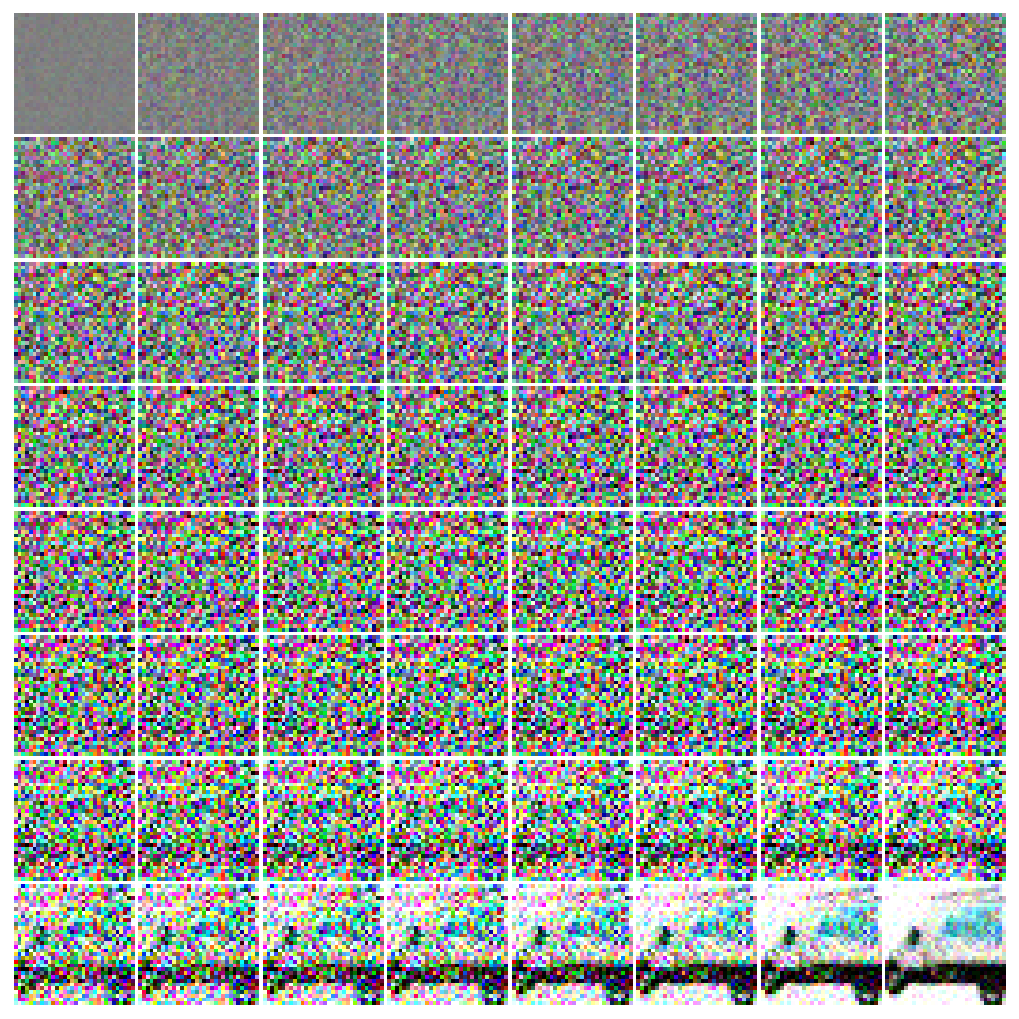

In [10]:
plot_images(ss[0:-1:8,k,:,:,:])